In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
import os
import contextlib


import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_recall_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap

In [2]:
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [3]:
# Load Dataset
data = pd.read_csv("clinical_data.csv")

In [4]:
# Step 1: Overview of the Dataset
print("Dataset Shape:", data.shape)
print("\nDataset Columns:\n", data.columns)
print("\nMissing Values:\n", data.isnull().sum())
print("\nUnique Values per Column:\n", data.nunique())

Dataset Shape: (989, 13)

Dataset Columns:
 Index(['patient_id', 'study_id', 'sex', 'age', 'race', 'histology',
       'smoking_status', 'stage', 'survival_months', 'survival_status',
       'egfr_mutated', 'kras_mutated', 'tp53_mutated'],
      dtype='object')

Missing Values:
 patient_id          0
study_id            0
sex                 0
age                35
race               62
histology           0
smoking_status     18
stage               7
survival_months    34
survival_status     4
egfr_mutated        0
kras_mutated        0
tp53_mutated        0
dtype: int64

Unique Values per Column:
 patient_id         989
study_id             3
sex                  2
age                 79
race                 4
histology            1
smoking_status       2
stage                4
survival_months    781
survival_status      2
egfr_mutated         2
kras_mutated         2
tp53_mutated         2
dtype: int64


In [5]:
# Step 2: Feature Distributions
# Numerical Feature Summary
numerical_features = ["age", "survival_months"]
print("\nSummary Statistics for Numerical Features:\n", data[numerical_features].describe())

# Categorical Feature Summary
categorical_features = ["sex", "race", "smoking_status", "stage", "survival_status"]
for feature in categorical_features:
    print(f"\nValue Counts for {feature}:\n", data[feature].value_counts())


Summary Statistics for Numerical Features:
               age  survival_months
count  954.000000       955.000000
mean    64.718303        38.674407
std     10.289043        33.390188
min     25.000000         0.000000
25%     58.000000        16.000000
50%     66.000000        28.500000
75%     72.000000        53.033333
max     88.000000       238.287800

Value Counts for sex:
 sex
female    564
male      425
Name: count, dtype: int64

Value Counts for race:
 race
caucasian           567
asian               312
african_american     47
other                 1
Name: count, dtype: int64

Value Counts for smoking_status:
 smoking_status
smoker        523
non_smoker    448
Name: count, dtype: int64

Value Counts for stage:
 stage
stage_1    520
stage_2    213
stage_3    205
stage_4     44
Name: count, dtype: int64

Value Counts for survival_status:
 survival_status
0.0    660
1.0    325
Name: count, dtype: int64


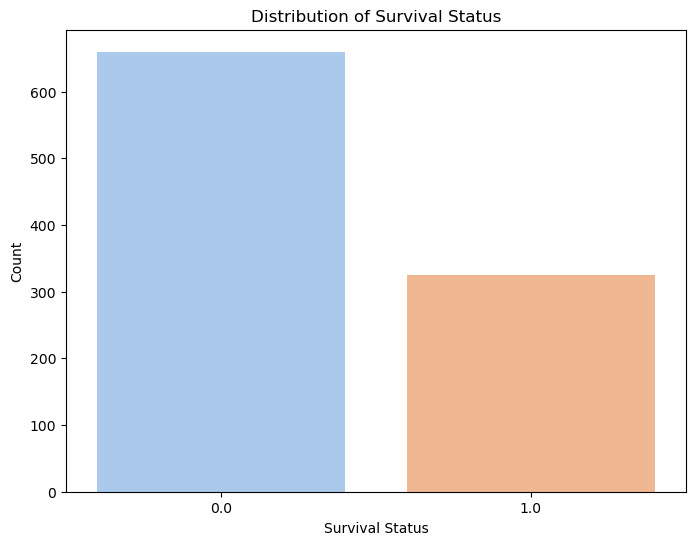

In [6]:
# Step 3: Visualizations
# Target Variable Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="survival_status", palette="pastel")
plt.title("Distribution of Survival Status")
plt.xlabel("Survival Status")
plt.ylabel("Count")
plt.show()

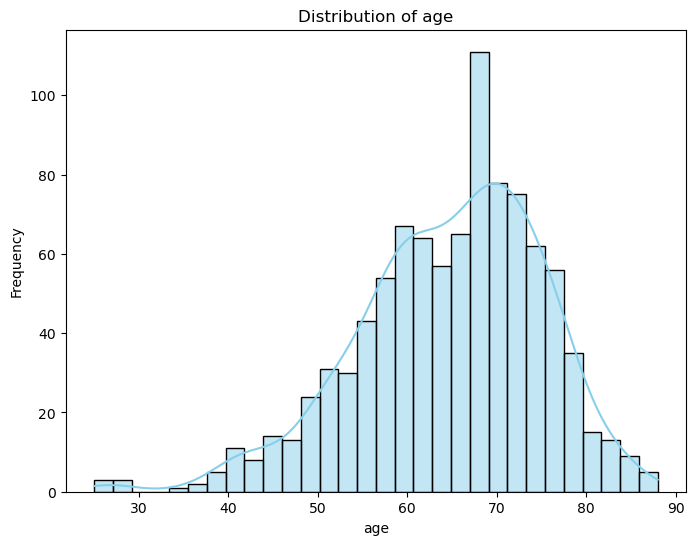

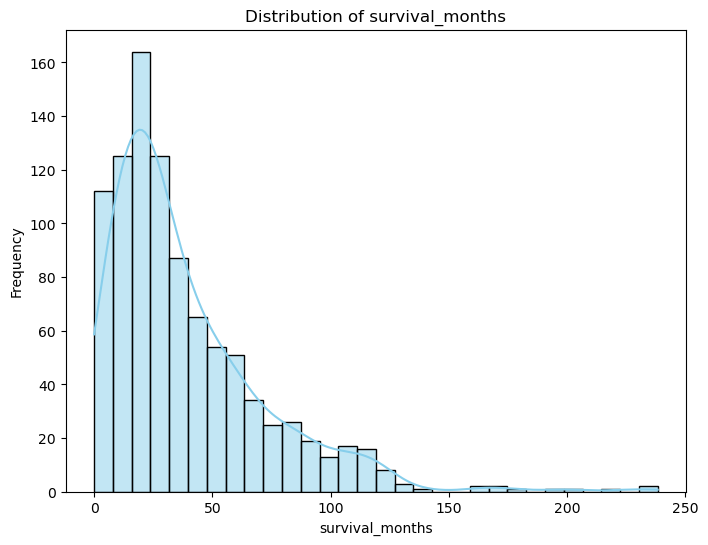

In [7]:
# Numerical Features Distribution
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

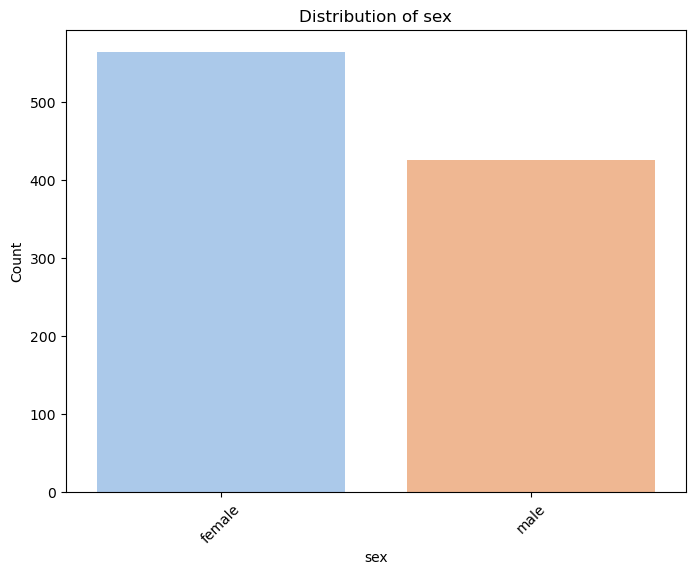

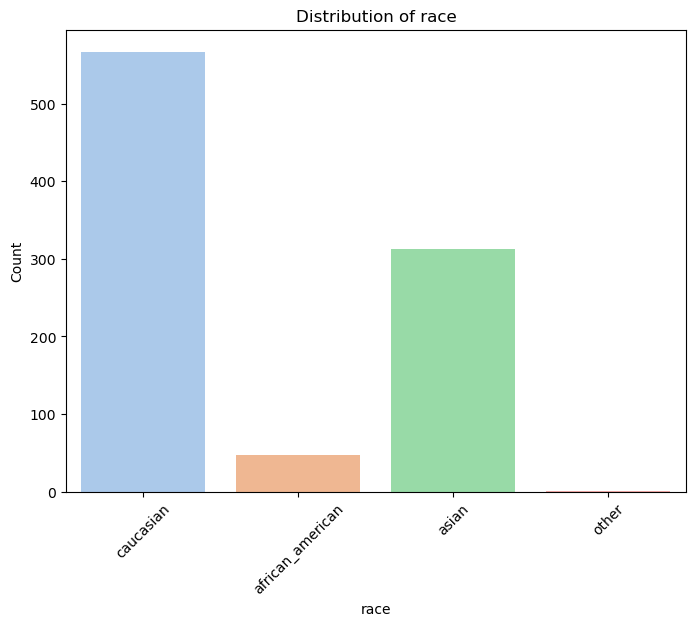

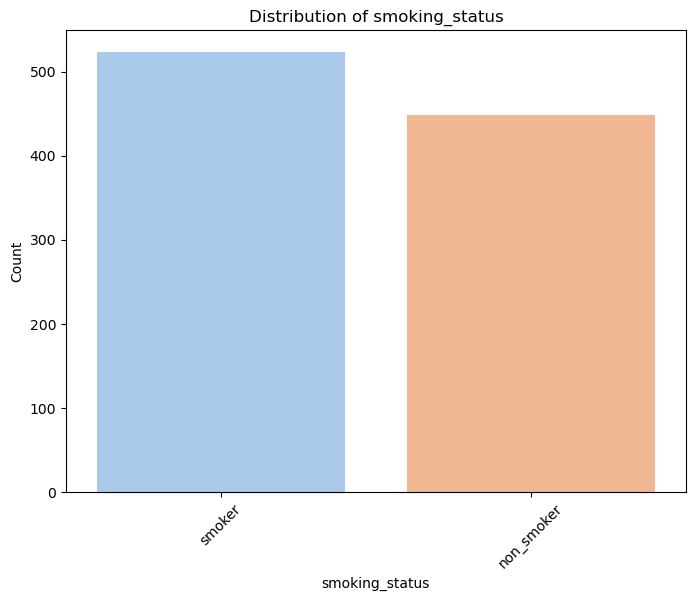

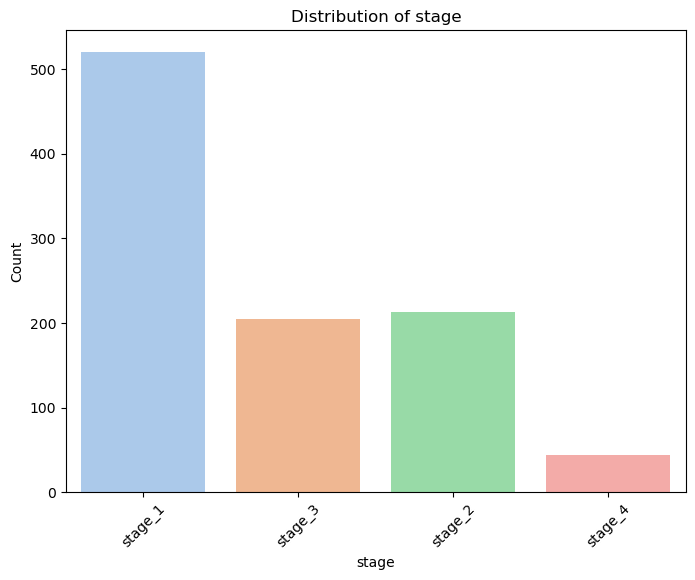

In [8]:
# Categorical Features Distribution
for feature in categorical_features:
    if feature != "survival_status":
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x=feature, palette="pastel")
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()

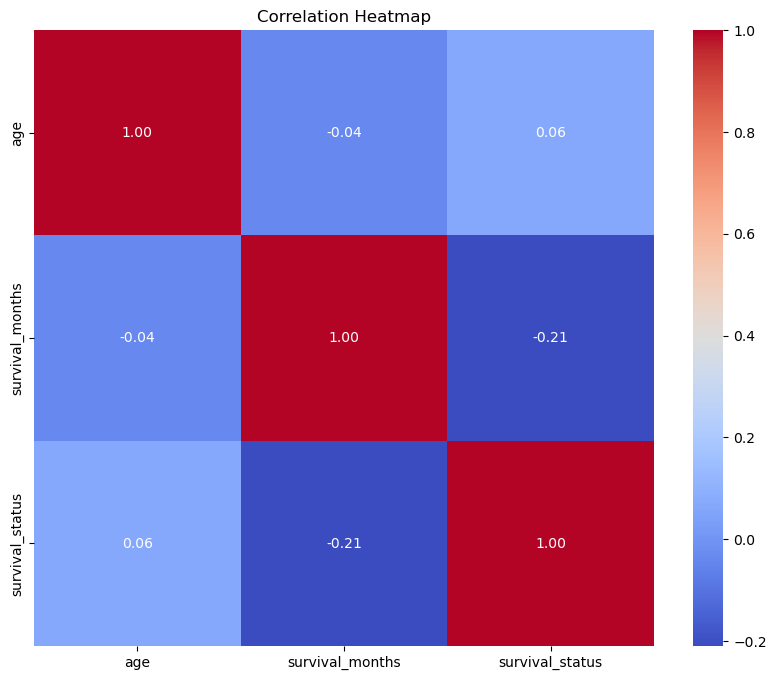

In [9]:
# Step 4: Correlation Analysis
# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
corr = data[numerical_features + ["survival_status"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

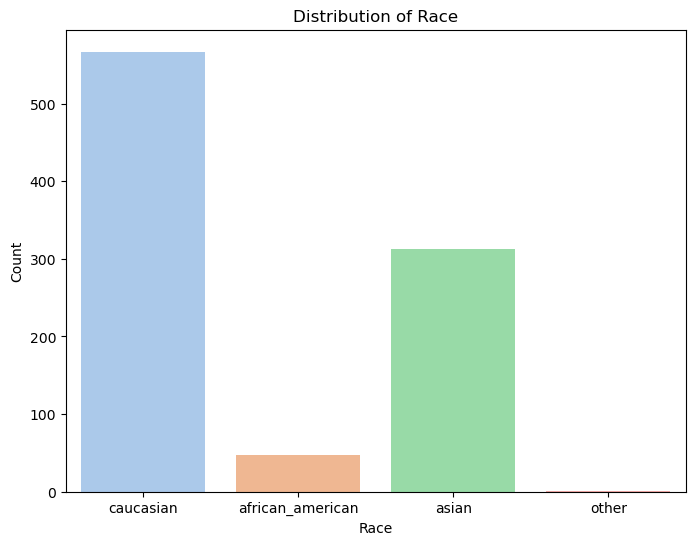

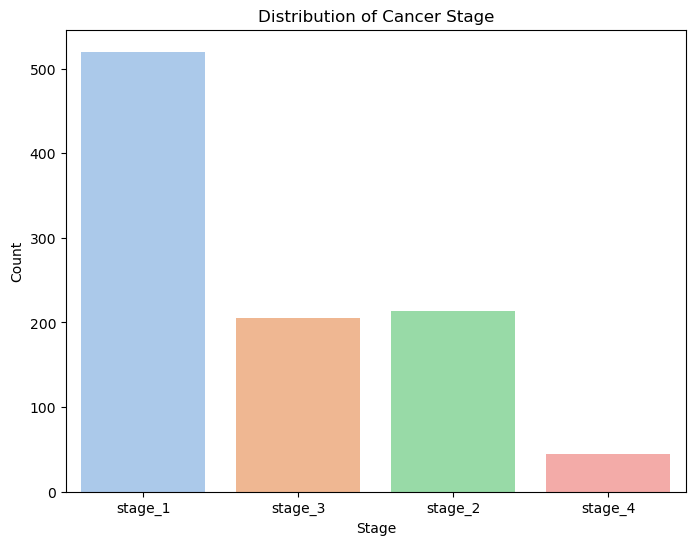

In [10]:
# Step 5: Race and Stage Imbalance Insights
# Insight: Check distributions of 'race' and 'stage'
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="race", palette="pastel")
plt.title("Distribution of Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="stage", palette="pastel")
plt.title("Distribution of Cancer Stage")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.show()

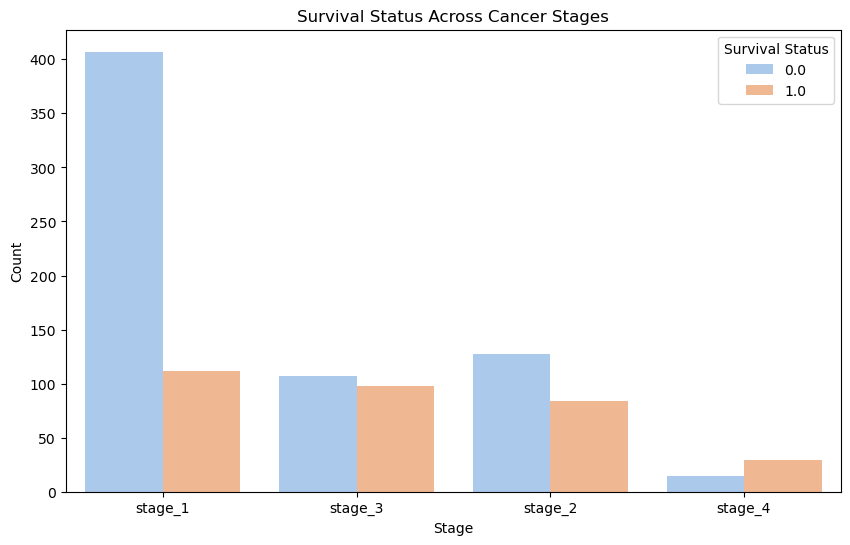

In [11]:
# Insight: Check survival status distribution across stages
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="stage", hue="survival_status", palette="pastel")
plt.title("Survival Status Across Cancer Stages")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.legend(title="Survival Status")
plt.show()

# Supervised ML models

### Step 1: Data Preparation

In [12]:
# Remove irrelevant features and handle missing data
data = data.drop(columns=["patient_id", "study_id", "histology"])  # Histology has only one unique value
data = data[data["race"] != "other"]  # Remove single example with 'other' in race
data = data.dropna()  # Drop rows with missing values for simplicity

# Define features and target variable
X = data.drop(columns=["survival_status"])
y = data["survival_status"]

### Step 2: Feature Engineering

In [13]:
categorical_features = ["sex", "race", "smoking_status", "stage"]
numerical_features = ["age", "survival_months"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

### Step 3: Optuna Optimization Function

In [14]:
def objective(trial, model_type):
    # Define hyperparameters
    if model_type == "random_forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        }
        model = RandomForestClassifier(class_weight="balanced", random_state=42, **params)
    elif model_type == "xgboost":
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        }
        model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", **params)
    elif model_type == "svm":
        params = {
            "C": trial.suggest_float("C", 0.1, 10.0),
            "gamma": trial.suggest_float("gamma", 0.01, 1.0),
            "kernel": trial.suggest_categorical("kernel", ["rbf", "linear"]),
        }
        model = SVC(probability=True, random_state=42, **params)

    # Define pipeline
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    
    # Stratified K-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring="recall")
    return scores.mean()

### Step 4: Optimize Models

In [19]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress Optuna logs

In [23]:
# Random Forest Optimization
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    rf_study = optuna.create_study(direction="maximize")
    rf_study.optimize(lambda trial: objective(trial, "random_forest"), n_trials=50)
    
print("Random Forest Best Params:", rf_study.best_params)

Random Forest Best Params: {'n_estimators': 245, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8}


In [24]:
# XGBoost Optimization
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(lambda trial: objective(trial, "xgboost"), n_trials=50)
print("XGBoost Best Params:", xgb_study.best_params)

XGBoost Best Params: {'learning_rate': 0.2738675798540935, 'max_depth': 10, 'n_estimators': 210, 'subsample': 0.6368386011660234, 'colsample_bytree': 0.7358712584571265}


In [25]:
# SVM Optimization
svm_study = optuna.create_study(direction="maximize")
svm_study.optimize(lambda trial: objective(trial, "svm"), n_trials=50)
print("SVM Best Params:", svm_study.best_params)

SVM Best Params: {'C': 9.598054079397583, 'gamma': 0.9964528596973266, 'kernel': 'rbf'}


### Step 5: Evaluation

In [26]:
def evaluate_model(model, model_name, X_test, y_test, pipeline):
    """
    Evaluates a model by:
    - Printing a classification report
    - Plotting precision-recall curve
    - Plotting ROC curve (if probabilities are available)
    - Plotting a confusion matrix
    """
    print(f"\nEvaluating {model_name}...")

    # Predict and calculate probabilities
    y_pred = pipeline.predict(X_test)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    if y_pred_proba is not None:
        PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        plt.title(f"Precision-Recall Curve for {model_name}")
    plt.grid()
    plt.show()

    # Plot ROC Curve if probabilities are available
    if y_pred_proba is not None:
        plt.figure(figsize=(8, 6))
        RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.title(f"ROC Curve for {model_name} (AUC = {auc:.2f})")
        plt.grid()
        plt.show()

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [27]:
#### Final models
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced", **rf_study.best_params)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", **xgb_study.best_params)
svm_model = SVC(probability=True, random_state=42, **svm_study.best_params)


Evaluating Random Forest...

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.62      0.69       119
         1.0       0.44      0.63      0.52        57

    accuracy                           0.62       176
   macro avg       0.61      0.63      0.61       176
weighted avg       0.67      0.62      0.64       176



<Figure size 800x600 with 0 Axes>

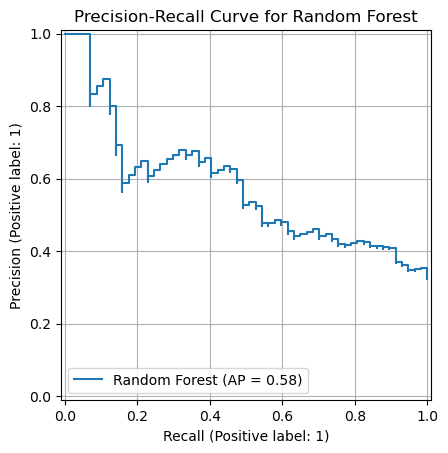

<Figure size 800x600 with 0 Axes>

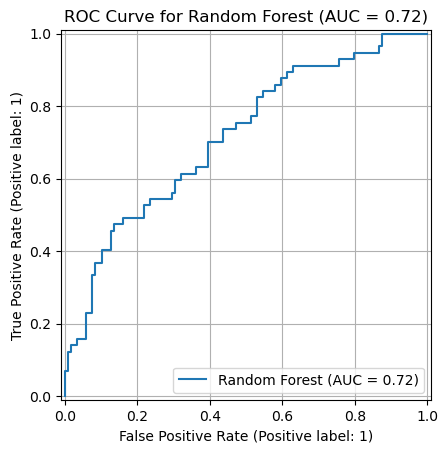

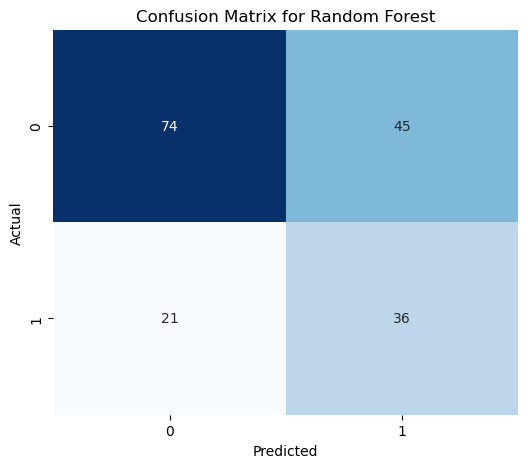

In [28]:
# Evaluate Random Forest
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_model)])
rf_pipeline.fit(X_train, y_train)
evaluate_model(rf_model, "Random Forest", X_test, y_test, rf_pipeline)


Evaluating XGBoost...

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       119
         1.0       0.53      0.46      0.49        57

    accuracy                           0.69       176
   macro avg       0.64      0.63      0.64       176
weighted avg       0.68      0.69      0.69       176



<Figure size 800x600 with 0 Axes>

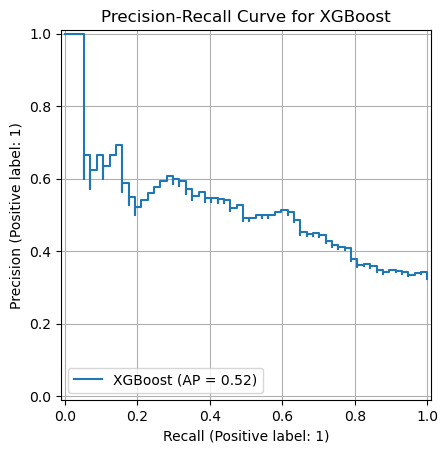

<Figure size 800x600 with 0 Axes>

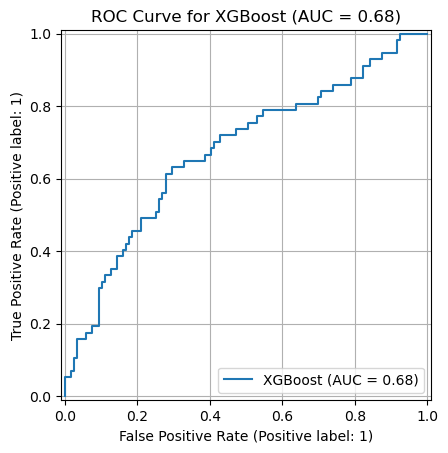

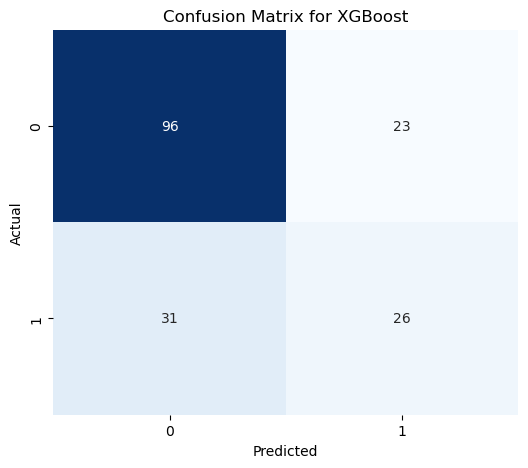

In [29]:
# Evaluate XGBoost
xgb_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb_model)])
xgb_pipeline.fit(X_train, y_train)
evaluate_model(xgb_model, "XGBoost", X_test, y_test, xgb_pipeline)


Evaluating SVM...

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.73      0.72       119
         1.0       0.42      0.40      0.41        57

    accuracy                           0.62       176
   macro avg       0.57      0.57      0.57       176
weighted avg       0.62      0.62      0.62       176



<Figure size 800x600 with 0 Axes>

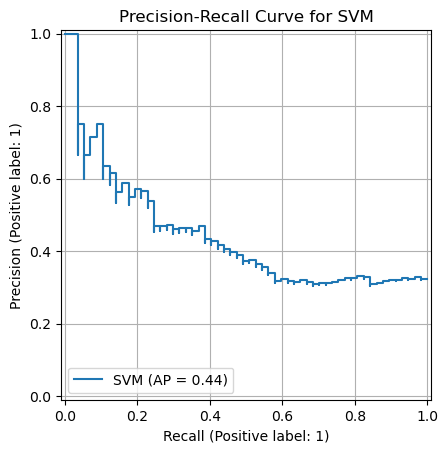

<Figure size 800x600 with 0 Axes>

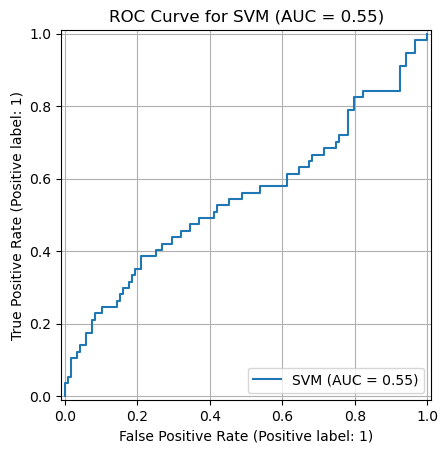

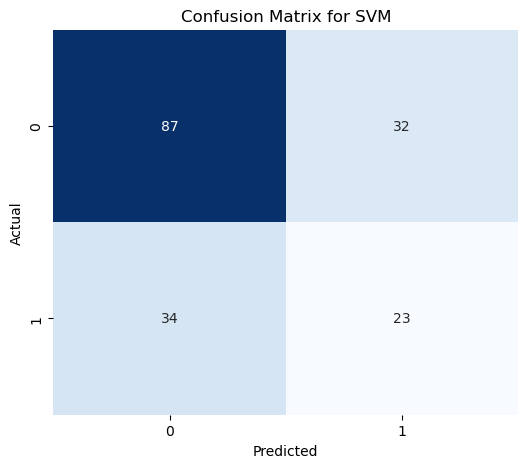

In [30]:
# Evaluate SVM
svm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", svm_model)])
svm_pipeline.fit(X_train, y_train)
evaluate_model(svm_model, "SVM", X_test, y_test, svm_pipeline)

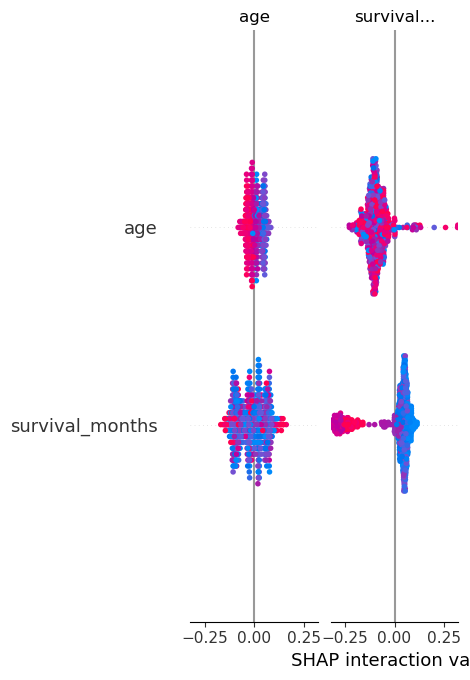

In [42]:
# Step 6: SHAP Analysis
# Ensure preprocessing is applied consistently
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Extract feature names
numerical_features = preprocessor.transformers_[0][2]
categorical_features_encoded = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_features_encoded)

# Create DataFrame with transformed data and feature names
X_train_shap = pd.DataFrame(X_train_transformed, columns=all_feature_names)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_pipeline.named_steps["classifier"])

# Compute SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train_shap)